In [3]:
!pip install pytorch-lightning captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 19.5 MB/s 
     |████████████████████████████████| 1.4 MB 57.4 MB/s 
     |████████████████████████████████| 125 kB 73.5 MB/s 
     |████████████████████████████████| 512 kB 72.3 MB/s 
     |████████████████████████████████| 87 kB 8.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=977c473d3898c7a261272914e772990a8f52da3a59366cb2f6095c60b582cade
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


In [4]:
!nvidia-smi

Wed Dec  7 12:58:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# black box training
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms, datasets
device = "cuda" if torch.cuda.is_available() else "cpu"

class pl_resnet18(pl.LightningModule):
    def __init__(self):
        super(pl_resnet18,self).__init__()
        self.model = ResNet(layers=[18,18,18,18],block=BasicBlock, num_classes=2)
        self.lr = 1e-3
        self.loss = nn.CrossEntropyLoss()
    def forward(self, x):
        return self.model.forward(x)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("train_loss", loss, on_epoch=True)
        return loss
    def validation_step(self, valid_batch, batch_idx):
        x, y = valid_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("val_loss", loss, on_epoch=True)
clf_resnet18 = pl_resnet18()

In [ ]:
clf_resnet18.load_state_dict(torch.load(f'./XAI-COURSE_2021/images/models/imagenette10_resnet18_red.pt'))
clf_resnet18.to(device)   
clf_resnet18.trainable = False

In [37]:
# -------- training ----------
# class Data(pl.LightningDataModule):
#     def prepare_data(self):   
#         train_data_dir = '/content/imagenette_red/train'  
#         val_data_dir = '/content/imagenette_red/val'  
#         transform = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor()])  
#         self.train_data = datasets.ImageFolder(train_data_dir, transform=transform)
#         self.val_data = datasets.ImageFolder(val_data_dir, transform=transform)
#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(self.train_data,batch_size=64,shuffle=True)
#     def val_dataloader(self):
#         return torch.utils.data.DataLoader(self.val_data,batch_size=64,shuffle=True)
# data = Data()
# logger = TensorBoardLogger("NN_logs", name=f"resnet18_imagenette_red", version=0)
# es = EarlyStopping(monitor="val_loss", mode="min")
# class LitProgressBar(TQDMProgressBar):
#     def init_validation_tqdm(self):
#         bar = tqdm(disable=True)
#         return bar
# bar = LitProgressBar()
# trainer = pl.Trainer(logger=logger, max_epochs=15, callbacks=[es,bar], enable_checkpointing=False, accelerator="gpu")
# trainer.fit(clf_resnet18,data)
# torch.save(clf_resnet18.state_dict(), f'/content/imagenette10_resnet18_red.pt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 111 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
446.036   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [37]:
# import numpy as np

# train_data_dir = './XAI-COURSE_2021/images/datasets/imagenette/train'  
# val_data_dir = './XAI-COURSE_2021/images/datasets/imagenette/val'  
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor()])  
# train_data = datasets.ImageFolder(train_data_dir, transform=transform)
# val_data = datasets.ImageFolder(val_data_dir, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=True)

# with torch.no_grad():
#     clf_resnet18.eval()
#     clf_resnet18.to('cuda')
#     train_accuracy = 0
#     for images, labels in train_loader:
#         output = clf_resnet18.forward(images.to('cuda')).argmax(dim=1).cpu().detach().numpy()
#         equality = (labels.data.numpy() == output)
#         train_accuracy += np.sum(equality)
#     print('train accuracy: ', train_accuracy/(len(train_loader)*32))
#     val_accuracy = 0
#     for images, labels in val_loader:
#         output = clf_resnet18.forward(images.to('cuda')).argmax(dim=1).cpu().detach().numpy()
#         equality = (labels.data.numpy() == output)
#         val_accuracy += np.sum(equality)
#     print('val accuracy: ', val_accuracy/(len(val_loader)*32))

train accuracy:  0.8948863636363636
val accuracy:  0.7475


In [ ]:
#val/parachute/n03888257_400.JPEG
#val/parachute/ILSVRC2012_val_00038942.JPEG
#train/parachute/ILSVRC2012_val_00010336.JPEG
#train/parachute/ILSVRC2012_val_00022496.JPEG
#train/golf_ball/n03445777_7184.JPEG
#train/golf_ball/n03445777_7794.JPEG
#val/golf_ball/n03445777_551.JPEG
#train/golf_ball/n03445777_759.JPEG

[[ 0.22742085 -2.0763316 ]]
prediction:  [0]


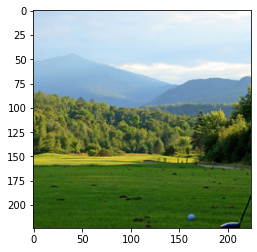

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

image = Image.open('/content/imagenette_red/val/golf_ball/n03445777_7212.JPEG')
image = transform(image).float()
plt.imshow(image.permute(1,2,0))
image = image.unsqueeze(0)

with torch.no_grad():
    pred = clf_resnet18.forward(image.to('cuda')).cpu().detach().numpy()

print(pred)
print('prediction: ',pred.argmax(axis=1))

In [ ]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(clf_resnet18)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = Image.open('/content/imagenette_red/val/golf_ball/n03445777_7212.JPEG')


# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    image = transform(image).float()
    image = image.unsqueeze(0)
    return image

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    with torch.no_grad():
        return clf_resnet18.forward(image.to('cuda')).cpu().detach().numpy()

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, 0, 'black', preprocessing, predict, model_type='pytorch')

plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

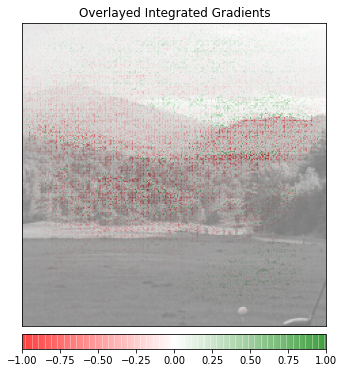

In [86]:
from captum.attr import visualization as viz

ig = IntegratedGradients(clf_resnet18)
# Computes integrated gradients for predicted class.
attribution = ig.attribute(image.to(device), target=int(pred.argmax(axis=1)))
_ = viz.visualize_image_attr(attribution[0,:].permute(1,2,0).cpu().numpy(), 
                             image[0,:].permute(1,2,0).cpu().numpy(), 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

pred:  [[-0.05777302 -1.7639426 ]]


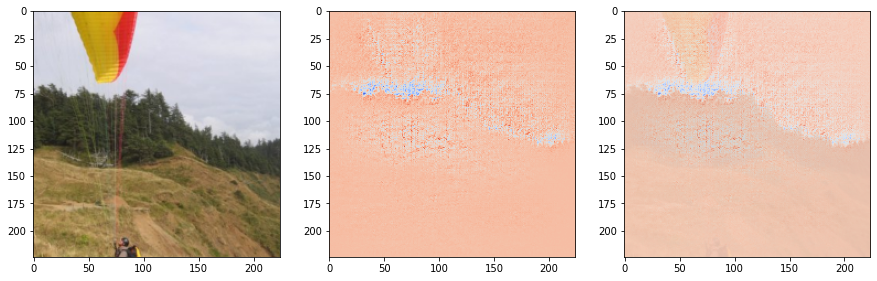

In [61]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
print('pred: ', pred)
ax[0].imshow(image[0,:].permute(1,2,0).numpy())
ax[1].imshow(np.sum(attribution[0,:].permute(1,2,0).detach().cpu().numpy(),axis=-1),cmap='coolwarm')
ax[2].imshow(image[0,:].permute(1,2,0).numpy(),alpha=0.3)
ax[2].imshow(np.sum(attribution[0,:].permute(1,2,0).detach().cpu().numpy(),axis=-1),cmap='coolwarm',alpha=0.7);